# Project Overview
This notebook presents the development of a modified ResNet architecture aimed at achieving high classification accuracy on the CIFAR-10 dataset, with the constraint of maintaining fewer than 5 million parameters. The project explores various architectural, optimization, and data processing strategies to meet these objectives.


In [ ]:
# Import necessary libraries, set random seeds for reproducibility, and define computing device
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define evaluate function to compute model accuracy on a given dataset
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
# Prepare data transformations, load CIFAR10 dataset, and set up training and testing data loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=100, shuffle=False)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:06<00:00, 28042028.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Define BasicBlock and ResNet model classes, including a custom ResNet model initialization function
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 66

        self.conv1 = nn.Conv2d(3, 66, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(66)


        self.layer1 = self._make_layer(block, 66, num_blocks[0], stride=1)

        self.layer2 = self._make_layer(block, 132, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 264, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(264 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNetCustom():
    return ResNet(BasicBlock, [3, 4, 3], num_classes=10)

model = ResNetCustom().to(device)

In [ ]:
# Define custom SmoothCrossEntropyLoss class for label-smoothing loss calculation
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [ ]:
# Setting up learning rate scheduler for adaptive learning rate adjustment during training
from torch.optim.lr_scheduler import LambdaLR
import math
model = ResNetCustom().to(device)
criterion = SmoothCrossEntropyLoss(smoothing=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

def warmup_with_cosine_lr(epoch):
    if epoch < 5:
        return epoch / 5
    else:
        return 0.5 * (1. + math.cos(math.pi * (epoch - 5) / (epochs - 5)))

scheduler = LambdaLR(optimizer, lr_lambda=warmup_with_cosine_lr)

In [ ]:
model_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of Trainable Parameters: {model_parameters}")

Number of Trainable Parameters: 4916284


In [ ]:
# Define the training loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train(epoch):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)
    print(f'Epoch: {epoch}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%')

def validate(epoch):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100. * correct / total)
    print(f'Epoch: {epoch}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

In [ ]:
# Training and evaluation loop
epochs = 60
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
lr_changes = []

for epoch in range(epochs):
    train(epoch)
    validate(epoch)
    scheduler.step()
    lr_changes.append(optimizer.param_groups[0]['lr'])

model_save_path = './model_weights.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0, Train Loss: 2.4132, Train Acc: 10.76%
Epoch: 0, Val Loss: 2.3967, Val Acc: 11.08%
Epoch: 1, Train Loss: 1.6181, Train Acc: 49.15%
Epoch: 1, Val Loss: 1.5646, Val Acc: 56.30%
Epoch: 2, Train Loss: 1.3206, Train Acc: 64.77%
Epoch: 2, Val Loss: 1.3412, Val Acc: 65.75%
Epoch: 3, Train Loss: 1.1885, Train Acc: 71.39%
Epoch: 3, Val Loss: 1.3391, Val Acc: 67.52%
Epoch: 4, Train Loss: 1.1152, Train Acc: 74.88%
Epoch: 4, Val Loss: 1.1641, Val Acc: 73.16%
Epoch: 5, Train Loss: 1.0671, Train Acc: 77.01%
Epoch: 5, Val Loss: 1.0711, Val Acc: 76.99%
Epoch: 6, Train Loss: 1.0100, Train Acc: 79.83%
Epoch: 6, Val Loss: 1.0254, Val Acc: 79.02%
Epoch: 7, Train Loss: 0.9786, Train Acc: 80.88%
Epoch: 7, Val Loss: 1.0319, Val Acc: 79.52%
Epoch: 8, Train Loss: 0.9464, Train Acc: 82.58%
Epoch: 8, Val Loss: 1.0027, Val Acc: 80.15%
Epoch: 9, Train Loss: 0.9225, Train Acc: 83.54%
Epoch: 9, Val Loss: 0.9849, Val Acc: 81.05%
Epoch: 10, Train Loss: 0.9066, Train Acc: 84.23%
Epoch: 10, Val Loss: 0.9103, Va

In [ ]:
test_accuracy = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")

Final Test Accuracy: 94.25%


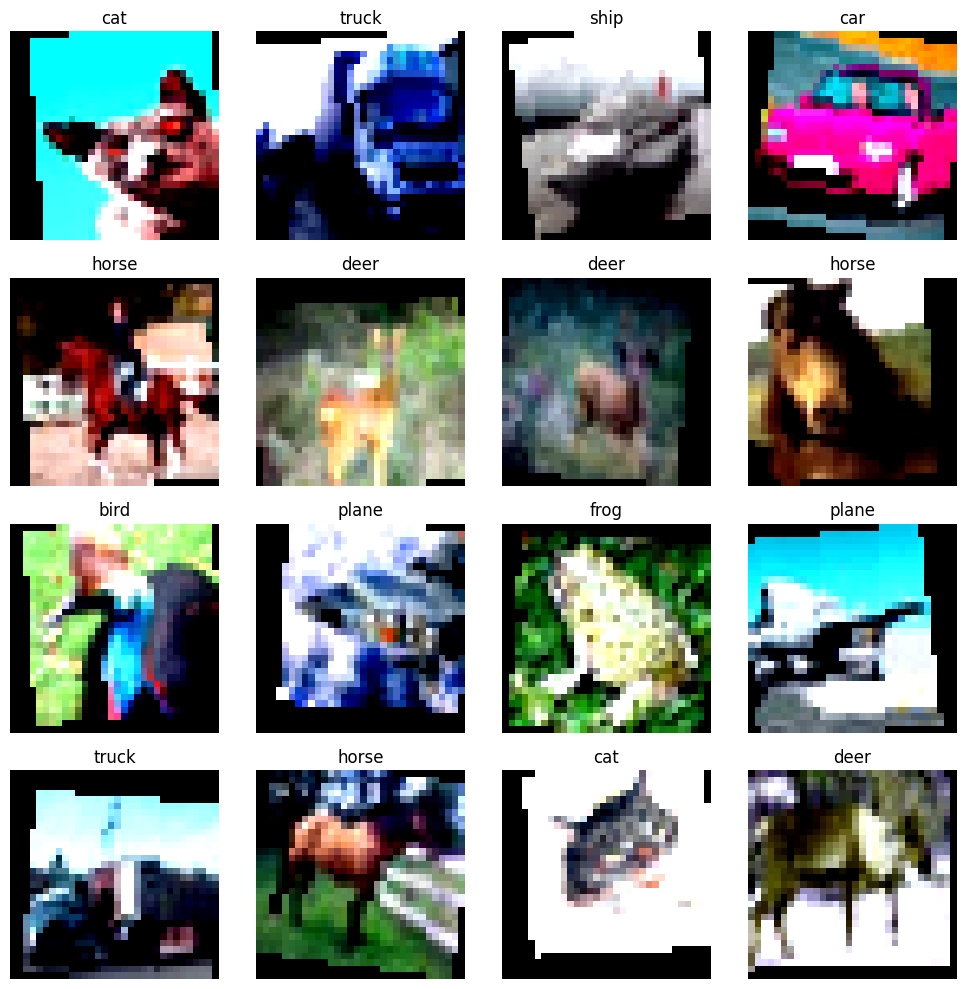

In [ ]:
# Define function to unnormalize, display image, visualize batch of training images with labels

def imshow(img):

    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

num_images = 16
rows = 4
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
axs = axs.ravel()

for i in range(num_images):
    axs[i].imshow(np.transpose((images[i] / 2 + 0.5).numpy(), (1, 2, 0)))
    axs[i].set_title(classes[labels[i]])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

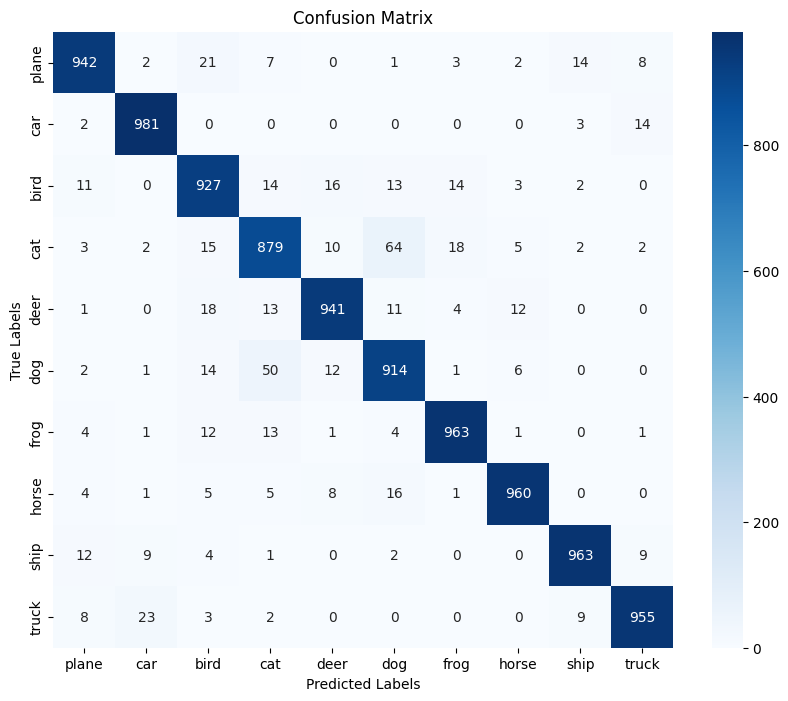

In [ ]:
# Evaluate model on test set to generate predictions, calculate confusion matrix, and visualize it

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).tolist())
        y_true.extend(labels.view(-1).tolist())

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

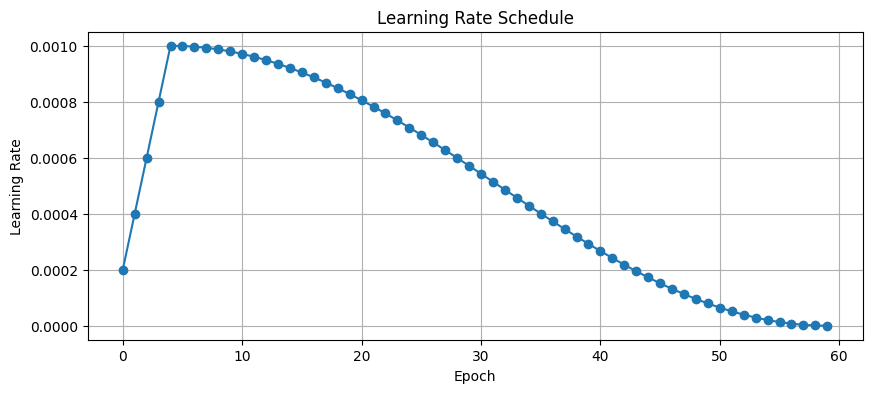

In [ ]:
# Plot learning rate schedule across epochs to visualize adjustments made by scheduler

plt.figure(figsize=(10, 4))
plt.plot(range(epochs), lr_changes, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

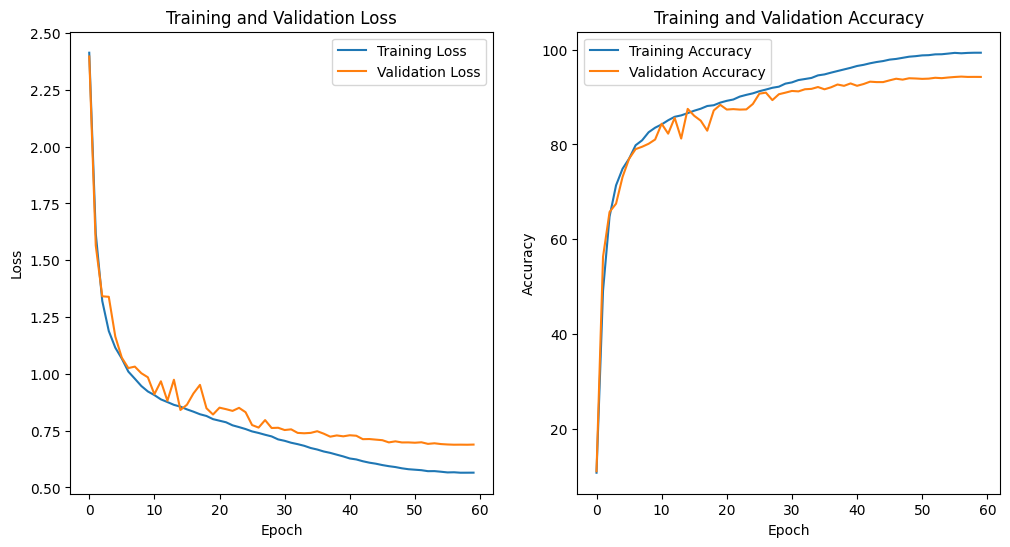

In [ ]:
# Visualize training, validation loss and accuracy on subplots to compare performance over epochs

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from torchsummary import summary

print(summary(model, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 66, 32, 32]           1,782
       BatchNorm2d-2           [-1, 66, 32, 32]             132
            Conv2d-3           [-1, 66, 32, 32]          39,204
       BatchNorm2d-4           [-1, 66, 32, 32]             132
            Conv2d-5           [-1, 66, 32, 32]          39,204
       BatchNorm2d-6           [-1, 66, 32, 32]             132
        BasicBlock-7           [-1, 66, 32, 32]               0
            Conv2d-8           [-1, 66, 32, 32]          39,204
       BatchNorm2d-9           [-1, 66, 32, 32]             132
           Conv2d-10           [-1, 66, 32, 32]          39,204
      BatchNorm2d-11           [-1, 66, 32, 32]             132
       BasicBlock-12           [-1, 66, 32, 32]               0
           Conv2d-13           [-1, 66, 32, 32]          39,204
      BatchNorm2d-14           [-1, 66,

In [ ]:
# System Specifications
import sys
import torch

!cat /proc/cpuinfo | grep 'model name' | uniq | awk -F: '{print "CPU:", $2}'
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader | awk '{$1=$1};1' | awk '{print "GPU:", $0}'
!cat /proc/meminfo | grep 'MemTotal' | awk '{print "System Memory:", $2/1024/1024, "GB"}'
print("Python Version:", sys.version)
print("CUDA version:", torch.version.cuda)
print("Torch Version:", torch.__version__)



CPU:  Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: Tesla V100-SXM2-16GB
System Memory: 50.9937 GB
Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
CUDA version: 12.1
Torch Version: 2.2.1+cu121
